# Imperfect HWP simulation

Normalized inverted_s_in: [ 1.00000000e+00  1.00870487e-02 -8.91549057e-05]
Normalized inverted_s_in: [ 1.00000000e+00  9.53907447e-03 -6.10000542e-04]
Normalized inverted_s_in: [ 1.00000000e+00  1.05203545e-02 -7.41341880e-06]
Normalized inverted_s_in: [1.00000000e+00 1.00582552e-02 3.77102405e-04]
Normalized inverted_s_in: [ 1.00000000e+00  9.56677248e-03 -4.07748953e-04]
Normalized inverted_s_in: [1.00000000e+00 9.47132821e-03 3.86715466e-04]
Normalized inverted_s_in: [1.00000000e+00 1.01920027e-02 2.37376067e-05]
Normalized inverted_s_in: [ 1.00000000e+00  1.05601412e-02 -4.63669600e-04]
Normalized inverted_s_in: [ 1.00000000e+00  1.01297392e-02 -6.31911552e-04]
Normalized inverted_s_in: [ 1.00000000e+00  1.01051909e-02 -8.90736919e-05]
Normalized inverted_s_in: [1.00000000e+00 9.78035641e-03 2.37697024e-04]
Normalized inverted_s_in: [1.00000000e+00 9.31952865e-03 4.72679760e-04]
Normalized inverted_s_in: [ 1.00000000e+00  9.66329249e-03 -1.46756732e-04]
Normalized inverted_s_in: [

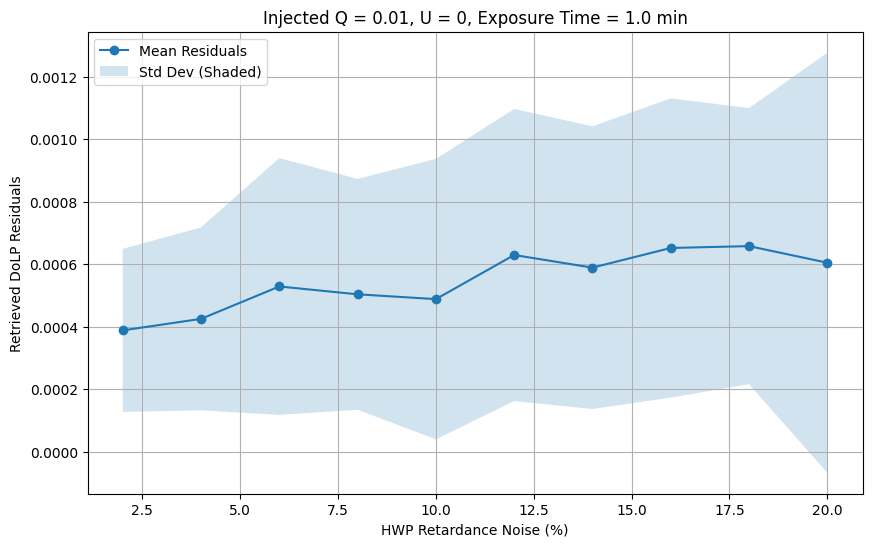

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../python/')
import angles
import instrument_mm

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    # {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
 ]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 1 second
num_samples = 200

# Injected polarization
Q_injected = 0.01  # Injected Stokes Q
U_injected = 0  # Injected Stokes U
noise_percentage = 0.1  # Intensity noise
matrix_noise = 0  # Fixed matrix noise (1%)

# For matrix inversion
include_V = False

# HWP retardance noise levels to test
HWP_noise_levels = np.arange(2, 22, 2) 
delta_HWP = 0.5
HWP_noise_type = "multiplicative"
num_trials = 50 # Number of trials per HWP retardance noise

import os
notebook_name = os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else 'imperfect_HWP_calibration'
output_dir = "/home/rebeccaz/Github/modhis_polarimetry_feasibility_study/results/numpy_files"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, notebook_name + ".txt")

for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over HWP noise levels
    for HWP_noise in HWP_noise_levels:
        residuals = []

        # Perform multiple trials for each HWP noise level
        for trial in range(num_trials):
            S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                delta_HWP=delta_HWP,
                noise_percentage=noise_percentage,
                include_V=include_V,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps=num_samples,
                matrix_noise_type=matrix_noise_type,
                HWP_noise=HWP_noise,
                HWP_noise_type = HWP_noise_type,
                normalize_s_out = True
            )
            
            # Calculate retrieved polarization
            Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
            retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
            injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)
            
            # Calculate absolute residuals
            residual = np.abs(injected_polarization - retrieved_polarization)
            residuals.append(residual)

        # Compute mean and standard deviation of residuals for this HWP noise level
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

    # Save summary data to txt file
    with open(output_path, "w") as f:
        for i, HWP_noise in enumerate(HWP_noise_levels):
            f.write(f"{HWP_noise}, {mean_residuals[i]:.8f}, {std_residuals[i]:.8f}, {target['name']}, {target['ra']}, {target['dec']}\n")

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)
    plt.plot(HWP_noise_levels, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(HWP_noise_levels, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"HWP Retardance Noise (%)")
    plt.ylabel("Retrieved DoLP Residuals")
    plt.title(
        f"Injected Q = {Q_injected}, U = {U_injected}, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()

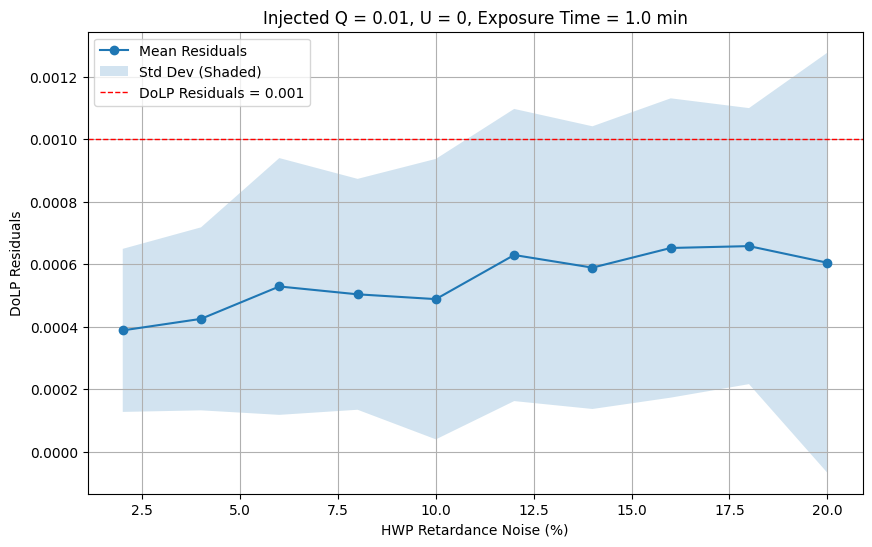

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 1 second
num_samples = 200

# Injected polarization
Q_injected = 0.01  # Injected Stokes Q
U_injected = 0  # Injected Stokes U
noise_percentage = 0.1  # Intensity noise
matrix_noise = 0  # Fixed matrix noise (1%)

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    # {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
 ]


# Fixed parameters for plotting
notebook_name = os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else 'imperfect_HWP_calibration'
output_dir = "/home/rebeccaz/Github/modhis_polarimetry_feasibility_study/results/numpy_files"
txt_path = os.path.join(output_dir, notebook_name + ".txt")

# Read in the saved txt file
data = []
with open(txt_path, "r") as f:
    for line in f:
        parts = line.strip().split(",")
        if len(parts) < 6:
            continue
        HWP_noise = float(parts[0])
        mean_residual = float(parts[1])
        std_residual = float(parts[2])
        target_name = parts[3].strip()
        target_ra = float(parts[4])
        target_dec = float(parts[5])
        data.append((HWP_noise, mean_residual, std_residual, target_name, target_ra, target_dec))

data = np.array(data, dtype=object)

# Plot the results for each target
for target in targets:
    mask = data[:,3] == target['name']
    HWP_noise_levels = data[mask,0].astype(float)
    mean_residuals = data[mask,1].astype(float)
    std_residuals = data[mask,2].astype(float)

    plt.figure(figsize=(10, 6))
    plt.plot(HWP_noise_levels, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(HWP_noise_levels, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.axhline(0.001, color='red', linestyle='--', linewidth=1, label='DoLP Residuals = 0.001')
    plt.xlabel(r"HWP Retardance Noise (%)")
    plt.ylabel("DoLP Residuals")
    plt.title(
        f"Injected Q = {Q_injected}, U = {U_injected}, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()